# Full Waveform Inversion with the Vector Reflectivity Wave Equation

In this tutorial, we perform an full waveform inversion (FWI) using forward and adjoint modeling acoustic  wave equations written in terms of P-wave velocity ($v_P$) and vector reflectivity ($\mathbf{R}$).

## Forward modeling

In [2]:
from examples.seismic.source import RickerSource, TimeAxis
from examples.seismic import setup_geometry, PointSource, Receiver
from examples.seismic import SeismicModel
from devito import (Eq, Operator, VectorTimeFunction, TimeFunction, TensorTimeFunction,
                    VectorFunction, solve)
from examples.seismic.stiffness import generic_elastic_setup
import numpy as np
import matplotlib.pyplot as plt
from devito import *
configuration['log-level'] = 'WARNING'

In [3]:
nx = 200
nz = 120

shape = (nx, nz)
spacing = (10., 10.)
origin = (0., 0.)
nlayers = 3
nbl = 50
space_order = 8
dtype = np.float32

# Model physical parameters:
vp = np.empty(shape, dtype=dtype)
rho = np.empty(shape, dtype=dtype)
b = np.empty(shape, dtype=dtype)

# Define a velocity profile. The velocity is in km/s
vp_top = 1.5
vp_bottom = 3.5
# define a velocity profile in km/s
v = np.empty(shape, dtype=dtype)
v[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, nlayers)
for i in range(1, nlayers):
    v[..., i*int(shape[-1] / nlayers):] = vp_i[i]  # Bottom velocity

rho[:] = 0.31*(v[:]*1000.)**0.25  # Gardner's relation
b[:] = 1./rho[:]  # Buoyancy.

In [4]:
model = SeismicModel(vp=v, b=b, origin=origin, space_order=space_order,
                     shape=shape, dtype=dtype, spacing=spacing, nbl=nbl)

model_smooth = SeismicModel(vp=v, b=b, origin=origin, space_order=space_order,
                     shape=shape, dtype=dtype, spacing=spacing, nbl=nbl)

gaussian_smooth(model_smooth.vp.data, 4)
gaussian_smooth(model_smooth.r[0].data, 4)
gaussian_smooth(model_smooth.r[1].data, 4)

Data([[0., 0., 0., ..., 0., 0., 0.],
      [0., 0., 0., ..., 0., 0., 0.],
      [0., 0., 0., ..., 0., 0., 0.],
      ...,
      [0., 0., 0., ..., 0., 0., 0.],
      [0., 0., 0., ..., 0., 0., 0.],
      [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
# function to plot P wave velocity, S wave velocity and density models
def img_model(img1, img2, img3, model, title=""):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    plt_options_model.update({'cmap': 'grey'})
    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title("$R_x$", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$R_z$", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

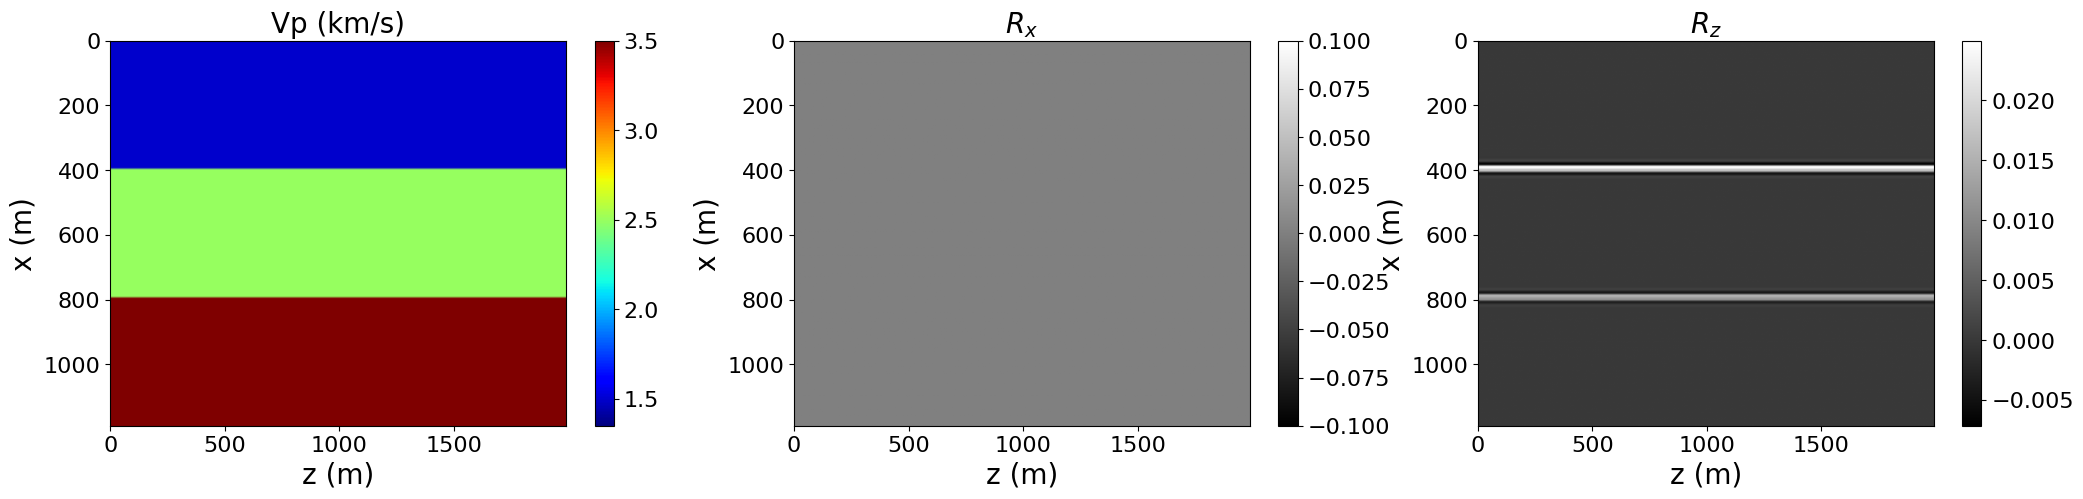

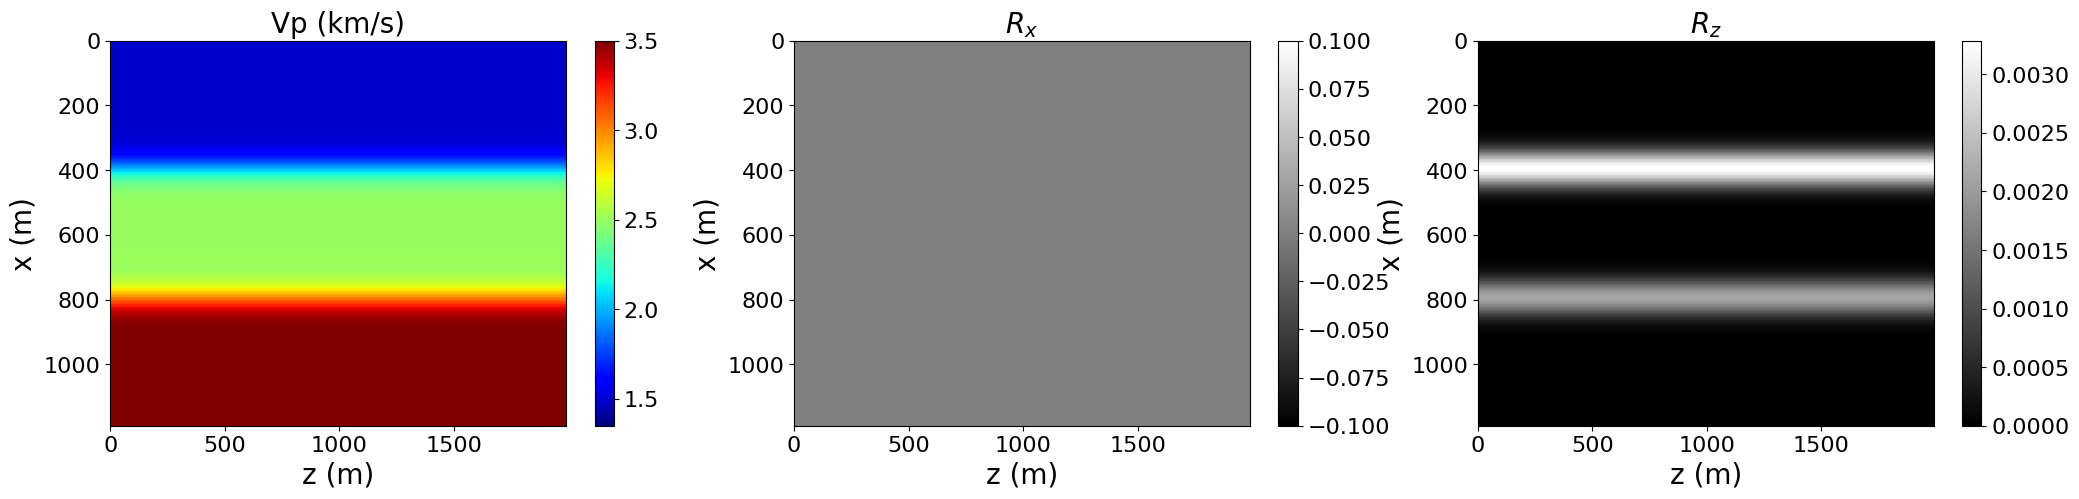

In [6]:
img_model(
    model.vp.data[nbl:-nbl,nbl:-nbl], 
    model.r[0].data[nbl:-nbl,nbl:-nbl], 
    model.r[1].data[nbl:-nbl,nbl:-nbl], 
    model
)

img_model(
    model_smooth.vp.data[nbl:-nbl,nbl:-nbl], 
    model_smooth.r[0].data[nbl:-nbl,nbl:-nbl], 
    model_smooth.r[1].data[nbl:-nbl,nbl:-nbl], 
    model_smooth
)

In [ ]:
f0 = 0.020  # peak/dominant frequency
rho = 1./model.b

s = model.grid.stepping_dim.spacing
damp = model.damp

# Time step in ms and time range:
t0, tn = 0., 1800.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

geometry = setup_geometry(model, tn, f0=f0)

In [8]:
def src_rec(model, geometry, src_pos, rec_depth, nrec):
    src = RickerSource(name='src', grid=model.grid, f0=geometry.f0, 
                       time_range=geometry.time_axis)

    rec = Receiver(name='rec', grid=model.grid, npoint=nrec,
                   time_range=geometry.time_axis)

    src.coordinates.data[:, 0] = src_pos[0]
    src.coordinates.data[:, 1] = src_pos[1]
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nrec)
    rec.coordinates.data[:, 1] = rec_depth
    
    return src, rec

## Building the forward  operator

The **elastic_forward(...)** function is responsible for forward modeling and makes use of the compact first-order elastic  equation system described below:

\begin{equation}
     \left\{\begin{array}{l}\rho \dfrac{\partial \vec{v}}{\partial t}-D \sigma=0,\\ 
     \dfrac{\partial \sigma}{\partial t}-C D^{T} \vec{v}=f_\sigma, \end{array}\right.
\end{equation}


In [9]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=2,
                    space_order=model.space_order, staggered=NODE,
                    save=geometry.nt)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - u.laplace + (- 1/vp*grad(vp) + 2*r).T * grad(u) + model.damp * u.dt

    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u

In [10]:
# generating a shot with the source in the center of the model

pos = np.empty((1, 2), dtype=np.float32)
pos[0, 0] = model.domain_size[0] * .5

src, rec = src_rec(model, geometry, pos[0], geometry.rec_positions[0,-1], geometry.nrec)
u = forward(model, geometry, src, rec)


## Plotting vx, vz and pressure fields shots

In [11]:
# # NBVAL_IGNORE_OUTPUT
# slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

# aspect_ratio = model.shape[0]/model.shape[1]

# plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0] +
#                                                  model.domain_size[0],
#                                                  model.origin[1] +
#                                                  model.domain_size[1],
#                                                  model.origin[1]]}
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

# scale = np.max(rec_vx.data) / 10.

# img1 = ax[0].imshow(rec_vx.data, vmin=scale, vmax=-scale, **plt_options_model)
# fig.colorbar(img1, ax=ax[0])
# ax[0].set_title(r"Shot $v_x$", fontsize=20)
# ax[0].set_xlabel('X (m)', fontsize=20)
# ax[0].set_ylabel('Time (s)', fontsize=20)
# ax[0].set_aspect('auto')

# scale2 = np.max(rec_vz.data) / 10.
# img2 = ax[1].imshow(rec_vz.data, vmin=scale2, vmax=-scale2, **plt_options_model)
# fig.colorbar(img2, ax=ax[1])
# ax[1].set_title("Shot $v_y$", fontsize=20)
# ax[1].set_xlabel('X (m)', fontsize=20)
# ax[1].set_ylabel('Time (s)', fontsize=20)
# ax[1].set_aspect('auto')

# scale3 = np.max(rec_sigma.data) / 10.
# img3 = ax[2].imshow(rec_sigma.data, vmin=scale3, vmax=-scale3, **plt_options_model)
# fig.colorbar(img3, ax=ax[2])
# ax[2].set_title(r"Shot ($\sigma_{xx}+\sigma_{zz}$)", fontsize=20)
# ax[2].set_xlabel('X (m)', fontsize=20)
# ax[2].set_ylabel('Time (s)', fontsize=20)
# ax[2].set_aspect('auto')

# plt.tight_layout()

## Plotting the wavefields snapshots for the particle velocity vector and the stress tensor components

In [12]:
# # NBVAL_IGNORE_OUTPUT
# # Some useful definitions for plotting if nbl is set to any other value than zero
# nxpad, nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
# shape_pad = np.array(shape) + 2 * nbl
# origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
# extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])
# # Note: flip sense of second dimension to make the plot positive downwards
# plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
#               origin_pad[1] + extent_pad[1], origin_pad[1]]


# def plot(a, title=None):
#     # Plot the wavefields, each normalized to scaled maximum of last time step
#     kt = (time_range.num - 2) - 1
#     amax = 10 * np.max(np.abs(a.data[kt, :, :]))

#     nsnaps = 9
#     factor = round(time_range.num / nsnaps)

#     fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
#     fig.suptitle(title, size=20)
#     for count, ax in enumerate(axes.ravel()):
#         snapshot = factor * (count + 1)
#         ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
#                   vmax=+amax, extent=plt_extent)
#         ax.plot(model.domain_size[0] * .5, 10, 'red', linestyle='None', marker='*',
#                 markersize=8, label="Source")
#         ax.grid()
#         ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
#         ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
#         ax.set_xlabel("X Coordinate (m)", fontsize=10)
#         ax.set_ylabel("Z Coordinate (m)", fontsize=10)


# plot(v[0], title="Snapshots $v_x$")
# plot(v[1], title="Snapshots $v_z$")
# plot(sigma[0], title="Snapshots $\sigma_{xx}$")
# plot(sigma[1], title="Snapshots $\sigma_{zz}$")
# plot(sigma[2], title="Snapshots $\sigma_{xz}$")

## Imaging condition

We use a source-normalized crosscorrelation imaging conditions for 2D images of the particle-velocity wavefields,
for a common-source gather, which can be formulated mathematically as:

\begin{equation}
I_{xx}(x,z)=\frac{\int^t_0 v_x(x,z,t)u_x(x,z,t)dt}{\int^t_0 v^2_x(x,z,t)dt}
\end{equation}

and

\begin{equation}
I_{zz}(x,z)=\frac{\int^t_0 v_z(x,z,t)u_z(x,z,t)dt}{\int^t_0 v^2_z(x,z,t)dt}
\end{equation}

where $I_{xx}$ and $I_{zz}$ represent the horizontal and vertical image components, respectively.

In [13]:
def GradientOperator(model, geometry, rec):
    u = TimeFunction(name='u', grid=model.grid, space_order=model.space_order, 
                           time_order=2, save=geometry.nt)
    v = TimeFunction(name='v', grid=model.grid, space_order=model.space_order, 
                           time_order=2)
    
    dJdvp = Function(name='dJdvp', grid=model.grid, space_order=model.space_order)
    dJdR = VectorFunction(name='dJdR', grid=model.grid, space_order=model.space_order)

    s = model.grid.stepping_dim.spacing

    m = model.m
    vp = model.vp
    r = model.r

    pde_v = m * v.dt2 - v.laplace - div((-grad(vp)/vp + 2*r) * v, .5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde_v, v.backward))]

    grad_update = [
        Inc(
            dJdvp,
            (-2/vp**3 * u.dt2 + (grad(vp)/vp).T * grad(u) + (u/vp).laplace)*v
        ),
        Inc(
            dJdR, 2*grad(u) * v
        )
    ]

    # Construct expression to inject receiver values
    rec_term = rec.inject(field=v.backward, expr=rec * s**2 / m)

    return Operator(stencil + grad_update + rec_term, 
             subs=model.spacing_map, name='Gradient')

# Applying the E-RTAM for 10 shots

The `img_final(...)` function is responsible for making the E-RTAM and the sum of the images of each shot, thus generating the final image.

In [14]:
nshots = 10
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.shape[0]*model.spacing[0],
                                     num=nshots)
source_locations[:, 1] = 10.


def img_final(model, model_smooth):
    dJdvp = Function(name='dJdvp', grid=model.grid, space_order=model.space_order)
    dJdR = VectorFunction(name='dJdR', grid=model.grid, space_order=model.space_order)

    for i in range(nshots):
        print('Imaging source %d out of %d' % (i+1, nshots))
        pos = source_locations[i, :]
        src, dcalc = src_rec(model, geometry, pos, geometry.rec_positions[0,-1], geometry.nrec)
        _, dtrue = src_rec(model, geometry, pos, geometry.rec_positions[0,-1], geometry.nrec)
        _, deltad = src_rec(model, geometry, pos, geometry.rec_positions[0,-1], geometry.nrec)
        forward(model, geometry, src, dtrue)
        u = forward(model_smooth, geometry, src, dcalc)

        deltad.data[:] = dtrue.data[:] - dcalc.data[:]

        op_grad = GradientOperator(model_smooth, geometry, deltad)
        op_grad(dt=dt, u=u, dJdvp=dJdvp, dJdR_x=dJdR[0], dJdR_y=dJdR[1])

    return dJdvp, dJdR

In [15]:
dJdvp, dJdR = img_final(model, model_smooth)

Imaging source 1 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 2 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 3 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 4 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 5 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 6 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 7 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 8 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 9 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


Imaging source 10 out of 10


/home/filipe/miniconda3/envs/devito/lib/python3.10/site-packages/sympy/matrices/matrixbase.py:2051: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  out = self.from_dok(self.rows, self.cols, fdok)


In [16]:
model_smooth.vp.data[:] -= dJdvp.data[:]
model_smooth.r[0].data[:] -= dJdR[0].data[:]
model_smooth.r[1].data[:] -= dJdR[1].data[:]

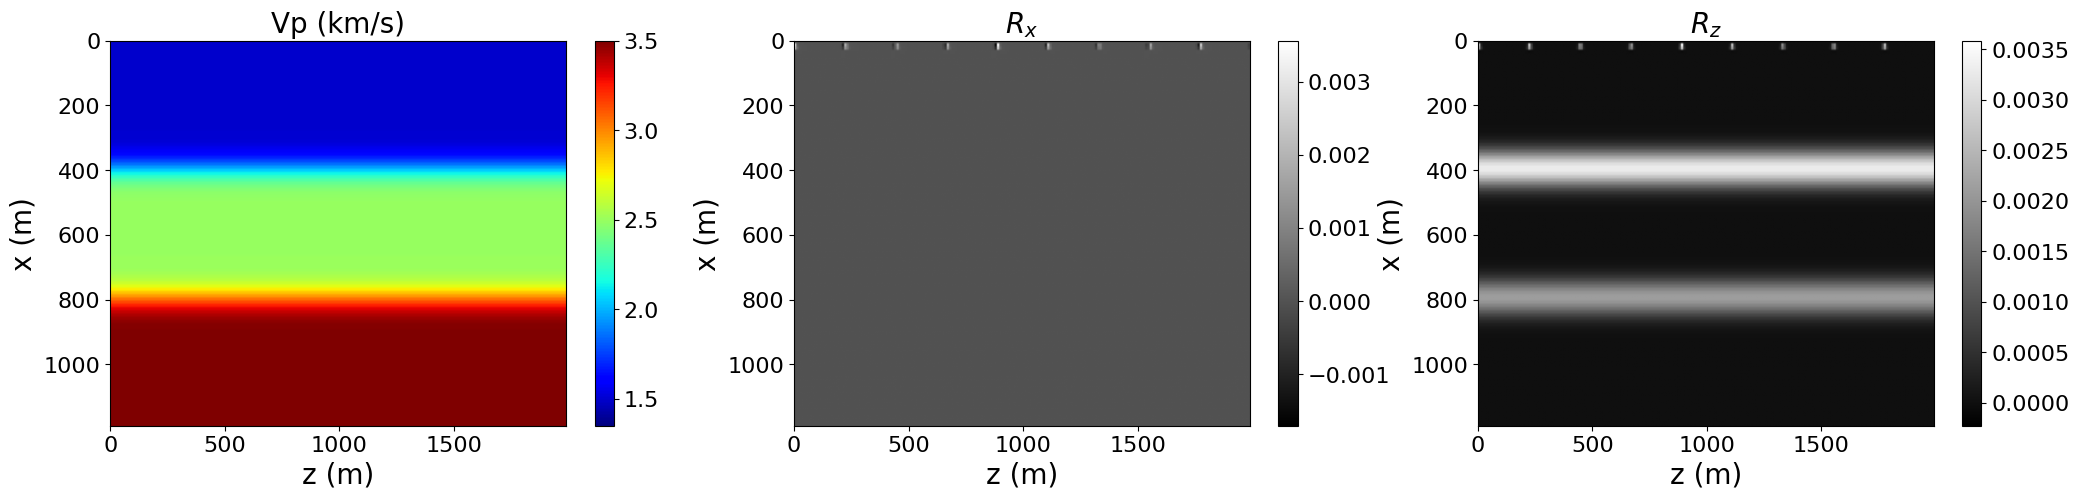

In [17]:
img_model(
    model_smooth.vp.data[nbl:-nbl,nbl:-nbl], 
    model_smooth.r[0].data[nbl:-nbl,nbl:-nbl], 
    model_smooth.r[1].data[nbl:-nbl,nbl:-nbl], 
    model_smooth
)

In [18]:
# Plotting for final image
def img(img, model, title=""):

    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

    plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0]
                                                     + model.domain_size[0],
                                                     model.origin[1] +
                                                     model.domain_size[1],
                                                     model.origin[1]]}
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    scale = np.max(img[0].data[slices])

    img1 = ax[0].imshow(np.transpose(img[0].data[slices]), vmin=scale, vmax=-scale,
                        **plt_options_model)
    fig.colorbar(img1, ax=ax[0])
    ax[0].set_title(title + "$I_{xx}$", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale2 = np.max(img[1].data[slices])

    img2 = ax[1].imshow(np.transpose(img[1].data[slices]), vmin=scale2, vmax=-scale2,
                        **plt_options_model)
    fig.colorbar(img2, ax=ax[1])
    ax[1].set_title(title + "$I_{zz}$", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')
    plt.savefig('Elastic' + title + '.pdf')

In [19]:
def lapla(model, image):
    lapla = VectorFunction(name='lapla', grid=model.grid, space_order=8)
    stencil = Eq(lapla, -image.laplace)
    op = Operator([stencil])
    op.apply()
    return lapla

In [20]:
# Applying laplacian filter
image_final_adj = lapla(model, imf_adj)

# Doing zero the water layer

image_final_adj[0].data[:, :90] = 0.
image_final_adj[1].data[:, :90] = 0.

img(imf_adj, model, title="")
img(image_final_adj, model, title="$\\nabla^2$")

NameError: name 'imf_adj' is not defined

## Adjoint test

The adjoint $A^{*}$ of an operator $A$ has the property:

\begin{equation}
<Ax,~y>=<x,~A^*y>
\end{equation}

where $x$ is the forward wavefield and $y$ is the adjoint wavefield.

In [ ]:
tn = 500.  # Final time

presets = {
    'layers-elastic': {'preset': 'layers-elastic', 'nlayers': 2},
}
# Create solver from preset
solver = iso_elastic_setup(shape=(20, 25), spacing=[15. for _ in shape], kernel=None,
                           nbl=10, tn=tn, space_order=2, time_order=1,
                           **(presets['layers-elastic']), dtype=np.float64)

# Create adjoint receiver symbol
srca = Receiver(name='srca', grid=solver.model.grid,
                time_range=solver.geometry.time_axis,
                coordinates=solver.geometry.src_positions)

# Run forward and adjoint operators
rec = solver.forward(save=False)[0]
solver.adjoint(rec=rec, srca=srca)

# Adjoint test: Verify <Ax,y> matches  <x, A^Ty> closely
term1 = np.dot(srca.data.reshape(-1), solver.geometry.src.data)
term2 = norm(rec) ** 2
print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
      % (term1, term2, (term1 - term2)/term1, term1/term2))


assert np.isclose((term1 - term2)/term1, 0., atol=1.e-11)

# References

<br>[1] **Time-domain elastic Gauss–Newton full-waveform inversion:
a matrix-free approach** (2020)
<br>Ke Chen and Mauricio D. Sacchi
<br>Geophysical Journal International
<br> https://doi.org/10.1093/gji/ggaa330


<br>[2] **Elastic least-squares reverse time migration** (2017)
<br>Zongcai Feng and Gerard T. Schuster
<br>GEOPHYSICS Technical Papers 
<br>https://doi.org/10.1190/geo2016-0254.1